In [3]:
import numpy as np
import textwrap
import matplotlib.pyplot as plt

import train_integers
from activations import *

examples = 569
neurons = 30
bitwidth = 20
fraction = 16
verbosity = "low"



def twos_comp(val, bits):
    """compute the 2's complement of int value val"""
    if (val & (1 << (bits - 1))) != 0: # if sign bit is set e.g., 8bit: 128-255
        val = val - (1 << bits)        # compute negative value
    return val                         # return positive value as is

In [5]:

with open("../../breast_input_30neuron_20bit_16frac.mem", 'r') as input_file:
    inputs = np.zeros((examples, neurons))
    text = input_file.readlines()
    for row, line in enumerate(text):
        elements = textwrap.wrap(line, bitwidth)
        elements = np.array([int(el, 2) for el in elements])
        inputs[row] = elements
        
    inputs = inputs.astype(int)
        
with open("../../breast_output_30neuron_20bit_16frac.mem", 'r') as output_file:
    outputs = np.zeros((examples, neurons))
    text = output_file.readlines()
    for row, line in enumerate(text):
        elements = textwrap.wrap(line, bitwidth)
        elements = np.array([int(el, 2) for el in elements])
        outputs[row] = elements
        
    outputs = outputs.astype(int)
        
with open("../../weights_30x30_20bit_16frac.mem", 'r') as weight_file:
    weights = np.zeros(neurons * neurons)
    text = weight_file.readlines()
    elements = textwrap.wrap(text[0], bitwidth)
    elements = np.array([int(el, 2) for el in elements])
    weights = elements
    weights = np.array([twos_comp(w, bitwidth) for w in weights])
    weights = weights.astype(int)

# This cell prints the values which should be seen in hardware

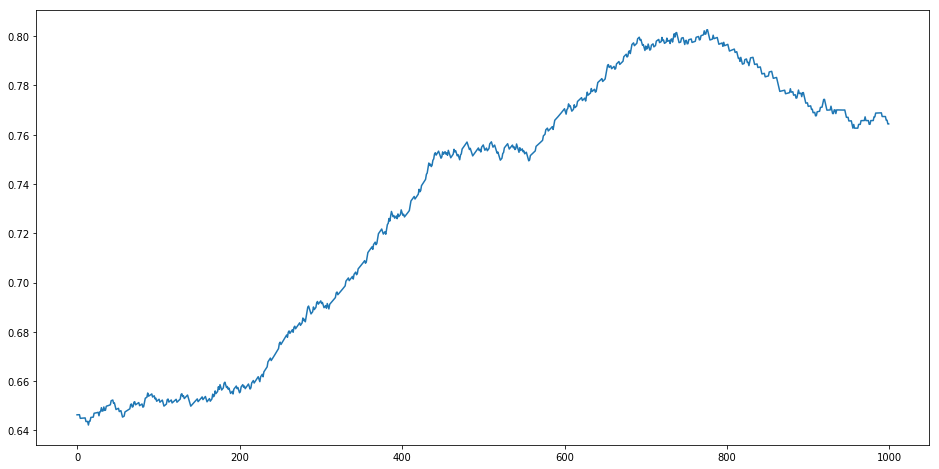

In [18]:
iter = 1000
x = inputs
y = outputs
w = weights.reshape(30, 30)
func = linear
func_der = linear_derivative
lr = 9
verbosity = "none"

classification = [] 

for i in range(iter): 
    sample = i % len(x)

    z0     = x[sample]
    target = y[sample]

    z1 = np.matmul(w, z0)
    a1 = func(z1)
    z1 = np.right_shift(z1, fraction)
    a1 = np.right_shift(a1, fraction)

    delta = (target - a1) * func_der(z1)
    delta = np.round(delta).astype(int)

    updates = delta.reshape(len(delta), 1) * z0.reshape(1, len(z0))
    updates = np.right_shift(updates, fraction)
    updates_shifted = np.right_shift(updates, lr)
    
    w_old = w
    w = w + updates_shifted
    
    classification.append(np.argmax(target[:2]) == np.argmax(a1[:2]))

    if verbosity == "low": 
        #print np.sum(np.abs(target - a1)) / 2.0**fraction
        print np.argmax(target[:2]) == np.argmax(a1[:2])
    if verbosity == "high":
        print("target", target)
        print("z0", z0)
        print("z1", z1)
        print('errors', target - z1)
        print("delta", delta)
        print("updates", updates)
        print("shifted", updates_shifted)
        print("w_old", w_old)
        print("w", w)


from scipy.signal import savgol_filter
smooth_classification = savgol_filter(classification, 1001, 2, mode="mirror")

fig = plt.figure(figsize=(16, 8))
plt.plot(smooth_classification)
plt.show()
